In [1]:
# import packages
import scipy.optimize as opt
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import os

In [2]:
# Define parameters

# Household Parameters
nvec = np.array([1.0,1.0,0.2])
yrs_live = 60
s = 3
beta = 0.442
sigma = 3

# Firm Parameters
alpha = 0.35
A = 1.0
delta_annual = 0.05
delta = 1- ((1 - delta_annual) ** (yrs_live/s))

In [3]:
# Define functions for calculating L, K, w, r

def get_L(nvec): # function for aggregate labor
    L = nvec.sum()
    return L

def get_K(bvec): # function for aggregate capital
    K = bvec.sum()
    return K

def get_w(K, L, params): # function for wage
    A, alpha = params
    w = (1 - alpha) * A * ((K / L) ** alpha)
    return w

def get_r(K, L, params): #function for interest rate
    A, alpha, delta = params
    r = alpha * A * ((L / K) ** (1 - alpha)) - delta
    return r

def get_Y(K, L, params):
    A, alpha = params
    Y = A * (K ** alpha) * (L ** (1 - alpha))
    return Y

## Problem 1

In [4]:
# define function that checks feasibility

def feasible(f_params, bvec_guess):
    nvec, A, alpha, delta = f_params
    
    K = get_K(bvec_guess)
    K_cnstr = K <= 0
    L = get_L(nvec)
    
    if not K_cnstr:
        w = get_w(K, L, (A, alpha))
        r = get_r(K, L, (A, alpha, delta))
        
        b = np.append([0], bvec_guess)
        b1 = np.append(bvec_guess, [0])
        cvec = (1 + r) * b + w * nvec - b1
        
        c_cnstr = cvec <= 0
        b_cnstr = c_cnstr[:-1] + c_cnstr[1:]
        
    else:
        c_cnstr = np.ones(cvec.shape[0], dtype = bool)
        b_cnstr = np.ones(cvec.shape[0] - 1, dtype = bool)
        
    return b_cnstr, c_cnstr, K_cnstr

In [5]:
f_params = (nvec, A, alpha, delta)
bvec_guess1 = np.array([1.0, 1.2])
bvec_guess2 = np.array([0.06, -0.001])
bvec_guess3 = np.array([0.1, 0.1])

print(feasible(f_params, bvec_guess1))
print(feasible(f_params, bvec_guess2))
print(feasible(f_params, bvec_guess3))

(array([ True, False], dtype=bool), array([ True, False, False], dtype=bool), False)
(array([False, False], dtype=bool), array([False, False, False], dtype=bool), False)
(array([False, False], dtype=bool), array([False, False, False], dtype=bool), False)


# 1(a)
The constraints for first period consumptions are violated. As a result, saving in the first period is likely to cause the violation in nonnegativity of consumptios.
# 1(b)
None of the constraints is violated.
# 1(c)
None of the constraints is violated.

## Problem 2

In [6]:
def errors(bvec, *args):
    
    A, alpha, delta, nvec, beta, sigma = args
    L = get_L(nvec)
    K = get_K(bvec)
    w = get_w(K, L, (A, alpha))
    r = get_r(K, L, (A, alpha, delta))
    
    b = np.append([0], bvec)
    b1 = np.append(bvec, [0])
    cvec = (1 + r) * b + w * nvec - b1
    
    muc = cvec ** (-sigma)
    
    EulErr_ss = muc[:-1] - beta * (1 + r) * muc[1:]
    
    return EulErr_ss

In [7]:
def get_SS(params, bvec_guess, SS_graphs = False):
    
    start_time = time.clock()
    
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    
    b = opt.root(errors, bvec_guess, args = (A, alpha, delta, nvec, beta, sigma), tol = SS_tol)
    if b.success:
        b_ss = b.x
        
    K_ss = get_K(b_ss)
    w_ss = get_w(K_ss, L, (A, alpha))
    r_ss = get_r(K_ss, L, (A, alpha, delta))
    Y_ss = get_Y(K_ss, L, (A, alpha))
    
    b = np.append([0], b_ss)
    b1 = np.append(b_ss, [0])
    c_ss = (1 + r_ss) * b + w_ss * nvec - b1
    C_ss = c_ss.sum()
    
    muc = c_ss ** (-sigma)
    EulErr_ss = muc[:-1] - beta * (1 + r_ss) * muc[1:]
    
    RCerr_ss = Y_ss - C_ss - delta * K_ss
    
    ss_time = time.clock() - start_time

    ss_output = {
        'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss,
        'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
        'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
        'ss_time': ss_time}
    
    print('\n Savings: \t\t\t {} \n Capital and Labor: \t\t {} \n Wage and Interest rate: \t {} \n Consumption: \t\t\t {}'.format(b_ss, np.array([K_ss, L]), np.array([w_ss, r_ss]), c_ss))
    
    print('Euler errors: ', EulErr_ss)
    print('Resource Constraint error: ', RCerr_ss)
    print('Time needed: ', ss_time)
    
    if SS_graphs:
        
        age = np.arange(1, 4)
        fig, ax = plt.subplots()
        plt.plot(age, c_ss, marker='D',label='Consumption')
        plt.plot(age, np.append([0], b_ss), marker = 'D', label='Savings')
        
        minorLocator = MultipleLocator(1)
        ax.xaxis.set_minor_locator(minorLocator)
        plt.grid(b=True, which='major', color='0.65', linestyle='-')
        plt.title('Steady-state consumption and savings')
        plt.xlabel('Age')
        plt.ylabel('Consumption units')
        plt.legend()
        plt.show()
        
    return ss_output

# 2(a) & (b)


 Savings: 			 [ 0.01931255  0.05841117] 
 Capital and Labor: 		 [ 0.07772372  2.2       ] 
 Wage and Interest rate: 	 [ 0.20172474  2.43304586] 
 Consumption: 			 [ 0.1824122   0.20961442  0.24087319]
Euler errors:  [ -1.36424205e-12   2.58637556e-12]
Resource Constraint error:  8.32667268469e-17
Time needed:  0.002770999999999857


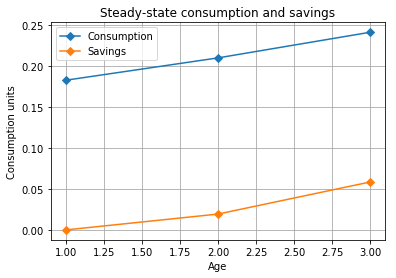

In [8]:
L = get_L(nvec)
SS_tol = 1e-9

params = (beta, sigma, nvec, L, A, alpha, delta, SS_tol)
bvec_guess = bvec_guess3
SS = get_SS(params, bvec_guess, SS_graphs = True)

# 2(c)
As we see in the cell below, when all households are more patient, $\bar{b}_2, \bar{b}_3$ both increase since consumption in future periods are more valuable for the households than before, resulting in their saving more today to further smooth consumption across periods.  
  
$\bar{K}$ increases because by market clearing, it is equal to the sum of $\bar{b}_2$ and $\bar{b}_3$; $\bar{L}$ remains unchanged because it is an exogenous variable.  

$\bar{w}$ increases and $\bar{r}$ decreases because $\frac{K}{L}$ increases. From firms' first order conditions, we know wage increases when capital-labor ratio increases, and interest rate decreases when capital labor ratio decrease (firms always optimize their capital-labor ratio according to prices).  

$\bar{c}_1, \bar{c}_2, \bar{c}_3$ all increase because income effect dominates intertemporal substitution effect--the increase in wage is much larger than the increase in households' savings for both periods.


 Savings: 			 [ 0.02817696  0.07686557] 
 Capital and Labor: 		 [ 0.10504253  2.2       ] 
 Wage and Interest rate: 	 [ 0.22415231  1.88636   ] 
 Consumption: 			 [ 0.19597535  0.22861559  0.26669216]
Euler errors:  [ -2.84217094e-14  -2.84217094e-14]
Resource Constraint error:  9.71445146547e-17
Time needed:  0.002136000000000138


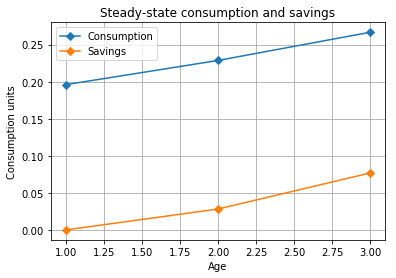

In [9]:
params_1 = (0.55, sigma, nvec, L, A, alpha, delta, SS_tol)
SS_new = get_SS(params_1, bvec_guess, SS_graphs = True)

## Problem 3

In [10]:
# TPI params
T = 30
max_iter = 300
TPI_tol = 1e-9
xi = 0.2

b_ss = SS['b_ss']
K_ss = SS['K_ss']
w_ss = SS['w_ss']
r_ss = SS['r_ss']

# Initial guess for capital stock
b1vec = np.array([0.8 * b_ss[0], 1.1 * b_ss[1]])
K1 = get_K(b1vec)
Kpath_old = np.zeros(T + 1)
Kpath_old[:-1] = np.linspace(K1, K_ss, T)
Kpath_old[-1] = K_ss

In [11]:
# Euler function error for the individual who is already born in period 1
def get_error(b3, *args):
    
    nvec, beta, sigma, b2, w_path, r_path = args
    n2, n3 = nvec
    w1, w2 = w_path
    r1, r2 = r_path
    c2 = (1 + r1) * b2 + w1 * n2 - b3
    c3 = (1 + r2) * b3 + w2 * n3
    muc2 = c2 ** (-sigma)
    muc3 = c3 ** (-sigma)
    error = muc2 - beta * (1 + r2) * muc3
    
    return error

# Euler function errors for other individuals
def get_errors(bvec, *args):
    
    nvec, beta, sigma, w_path, r_path = args
    b = np.append([0], bvec)
    b1 = np.append(bvec, [0])
    cvec = (1 + np.append([0], r_path)) * b + w_path * nvec - b1
    
    muc = cvec ** (-sigma)
    errors = muc[:-1] - beta * (1 + r_path) * muc[1:]
    
    return errors

In [12]:
abs2 = 1
tpi_iter = 0
L = get_L(nvec)

while abs2 > TPI_tol and tpi_iter < max_iter:
    tpi_iter = tpi_iter + 1
    w_path = get_w(Kpath_old, L, (A, alpha))
    r_path = get_r(Kpath_old, L, (A, alpha, delta))
    # Initialize savings matrix
    b = np.zeros((2, T + 1))
    b[:, 0] = b1vec
    # solve for b32
    b32 = opt.root(get_error, b[1, 0], args=(nvec[1:], beta, sigma, b[0, 0], w_path[:2], r_path[:2]))
    b[1, 1] = b32.x
    
    for t in range(T - 1):
        bvec_guess = np.array([b[0, t], b[1, t + 1]])
        bt = opt.root(get_errors, bvec_guess, (nvec, beta, sigma, w_path[t : t + 3], r_path[t + 1: t + 3]))
        b[0, t + 1] = bt.x[0]
        b[1, t + 2] = bt.x[1]
    # Calculate the implied capital stock from conjecture and the error
    Kpath_new = b.sum(axis = 0)
    abs2 = ((Kpath_old[:] - Kpath_new[:]) ** 2).sum()
    # Update guess
    Kpath_old = xi * Kpath_new + (1 - xi) * Kpath_old
    print('iteration:', tpi_iter, ' squared distance: ', abs2)

iteration: 1  squared distance:  0.000401499739002
iteration: 2  squared distance:  0.000282697186267
iteration: 3  squared distance:  0.000200269182054
iteration: 4  squared distance:  0.000142659554267
iteration: 5  squared distance:  0.000102125095821
iteration: 6  squared distance:  7.34304922882e-05
iteration: 7  squared distance:  5.30052886235e-05
iteration: 8  squared distance:  3.83943542995e-05
iteration: 9  squared distance:  2.78963861813e-05
iteration: 10  squared distance:  2.03239423664e-05
iteration: 11  squared distance:  1.48427205132e-05
iteration: 12  squared distance:  1.08629706744e-05
iteration: 13  squared distance:  7.96551219146e-06
iteration: 14  squared distance:  5.8509209938e-06
iteration: 15  squared distance:  4.3043647816e-06
iteration: 16  squared distance:  3.1710937589e-06
iteration: 17  squared distance:  2.33924518326e-06
iteration: 18  squared distance:  1.7277059591e-06
iteration: 19  squared distance:  1.27749806582e-06
iteration: 20  squared di

# 3(a)

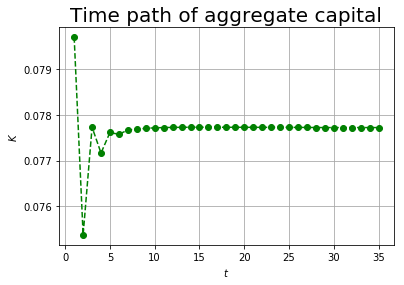

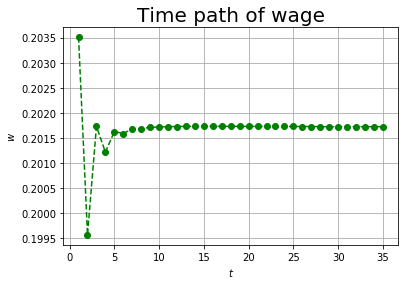

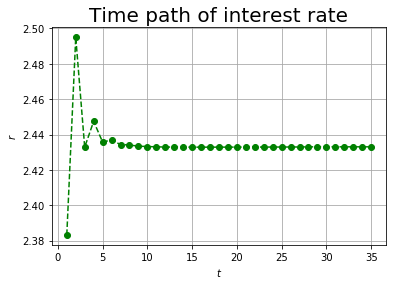

In [13]:
plt.plot(1 + np.arange(T + 5), np.append(Kpath_old[:T-2], K_ss * np.ones(7)), 'go--')
plt.grid(b=True, which='major', color='0.65', linestyle='-')
plt.title('Time path of aggregate capital', fontsize=20)
plt.xlabel(r'$t$')
plt.ylabel(r'$K$')
plt.show()

w_path = get_w(Kpath_old, L, (A, alpha))
r_path = get_r(Kpath_old, L, (A, alpha, delta))

plt.plot(1 + np.arange(T + 5), np.append(w_path[:T-2], w_ss * np.ones(7)), 'go--')
plt.grid(b=True, which='major', color='0.65', linestyle='-')
plt.title('Time path of wage', fontsize=20)
plt.xlabel(r'$t$')
plt.ylabel(r'$w$')
plt.show()

plt.plot(1 + np.arange(T + 5), np.append(r_path[:T-2], r_ss * np.ones(7)), 'go--')
plt.grid(b=True, which='major', color='0.65', linestyle='-')
plt.title('Time path of interest rate', fontsize=20)
plt.xlabel(r'$t$')
plt.ylabel(r'$r$')
plt.show()

In [14]:
k_first = [k for k in Kpath_old if abs(k - K_ss) < 0.00001][0]
print(k_first)
T1 = np.where(Kpath_old == k_first)[0][0]
print(T1+1)

k_last = [k for k in Kpath_old[:-3] if abs(k- K_ss) > 0.00001][-1]
print(k_last)
T2 = np.where(Kpath_old == k_last)[0][0]
print(T2+1)

0.0777309790492
3
0.0777093470076
9


In period 3, the economy first gets to within 0.00001 of the steady state. After period 9, the economy is never again father than 0.00001 away from the steady state.